In [1]:

import numpy as np
import matplotlib.pyplot as plt
import random as random
import math as math
from WeinerGenerator import getWeiner, getWeinerSubset
from tqdm.notebook import trange, tqdm

b = -0.05

t0 = 0
tend = 1
steps = 100000
dt = (tend-t0)/steps
h = 1.0
threshold = h/2
Kbar = 1.0

def K(z):
    if z <= threshold:
        K = z*(h-2*z)*Kbar
    else:
        K = (h-z)*(-h+2*z)*Kbar
    return K

def dKdz(z):
    if z <= threshold:
        dKdz = h-4*z
    else:
        dKdz = 3*h-4*z
    return dKdz

def dgdz(z):
    #print(z)
    if z < threshold and z > 0:
        dgdz = math.sqrt(2) * (h - 4 * z) / (2 * math.sqrt(z * (h - 2 * z)))
    elif z > threshold and z < h:
        dgdz = math.sqrt(2) * (3 * h - 4 * z) / (2 * math.sqrt(-h**2 + 3 * h * z - 2 * z**2))
    else:
        dgdz = 0
    return dgdz

class Particle():
    def __init__(self, z):
        self.z = z

    def simulate(self, ts, dws, dt):
        self.dt = dt
        self.ts = ts
        self.zs = []
        for index, t in enumerate(ts):
            #Story history
            self.zs.append(self.z)

            #Advance
            z0 = self.z
            z1 = z0 + dKdz(z0)*dt + math.sqrt(2*K(z0))*dws[index] #last dws gets used here but the last resulting zs doesn't get stored

            #Store result
            self.z = z1 

            #Correct if out of bounds
            self.correctBounds()

        return self.zs

    def simulate_Milstein(self,ts,dws,dt):
        zs = []
        for index, t in enumerate(ts):
            z0 = self.z
            # z1 = z0 + dKdz(z0)*dt + math.sqrt(2*K(z0))*random.gauss(0,1)*math.sqrt(dt)#*randomFactor # Euler
            z1 = z0 + dKdz(z0) * dt + math.sqrt(2 * K(z0)) * random.gauss(0,1) * math.sqrt(dt) + 0.5 * math.sqrt(2 * K(z0)) * dgdz(z0) * (random.gauss(0,1)**2 * dt - dt)
            # print(z0, z1)
            if z1 < 0:
                z1 = -z1
            if z1 > h:
                # z1 = 2*h-z1
                z1 = 0.99 # If using Milstein the above won't assure the particles stay within range
            self.z = z1 
        return z1


    def correctBounds(self):
        if abs(self.z) > 2*h:
            print("Severe out of bounds")
            exit()
        if self.z < 0:
            self.z = - self.z
        if self.z > h:
            self.z = 2*h - self.z
        return


No handles with labels found to put in legend.


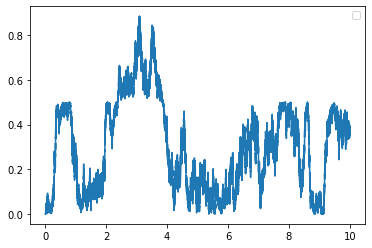

In [2]:
def plotRealization():
    ts, ws, dws, dt = getWeiner(1000000,10,0)
    particle = Particle(0)
    zs = particle.simulate(ts, dws, dt)

    plt.plot(ts,zs)

plotRealization()

plt.legend()
plt.show()

  0%|          | 0/108 [00:00<?, ?it/s]

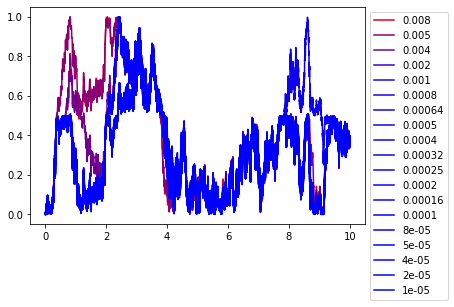

In [3]:
def plotRealizationConvergence(nth):
    ts, ws, dws, dt = getWeinerSubset(nth,1000000,10,0)
    particle = Particle(0)
    zs = particle.simulate(ts, dws, dt)

    plt.plot(ts,zs, label = dt, color = (1-(maxnth-nth)/maxnth, 0, 1-nth/maxnth))

iterlist = np.concatenate((np.arange(1,100), np.arange(1,10)*100))
iterlist = iterlist[::-1] #reverse iterlist to plot highest resolution last
maxnth = iterlist[0]

for i in tqdm(iterlist):
    if 1000000%i == 0:
        plotRealizationConvergence(i)

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Interpolation test below


  0%|          | 0/9 [00:00<?, ?it/s]

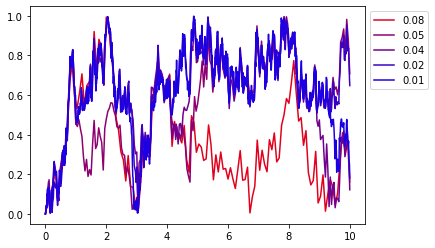

  0%|          | 0/5 [00:00<?, ?it/s]

0.08
0.05
0.04
0.02
0.01


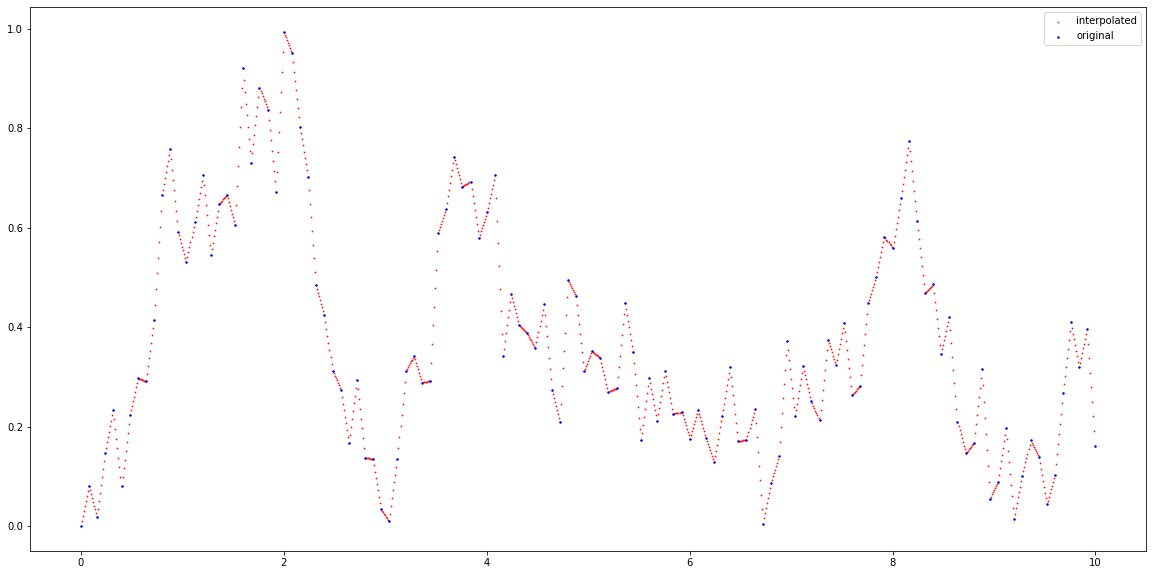

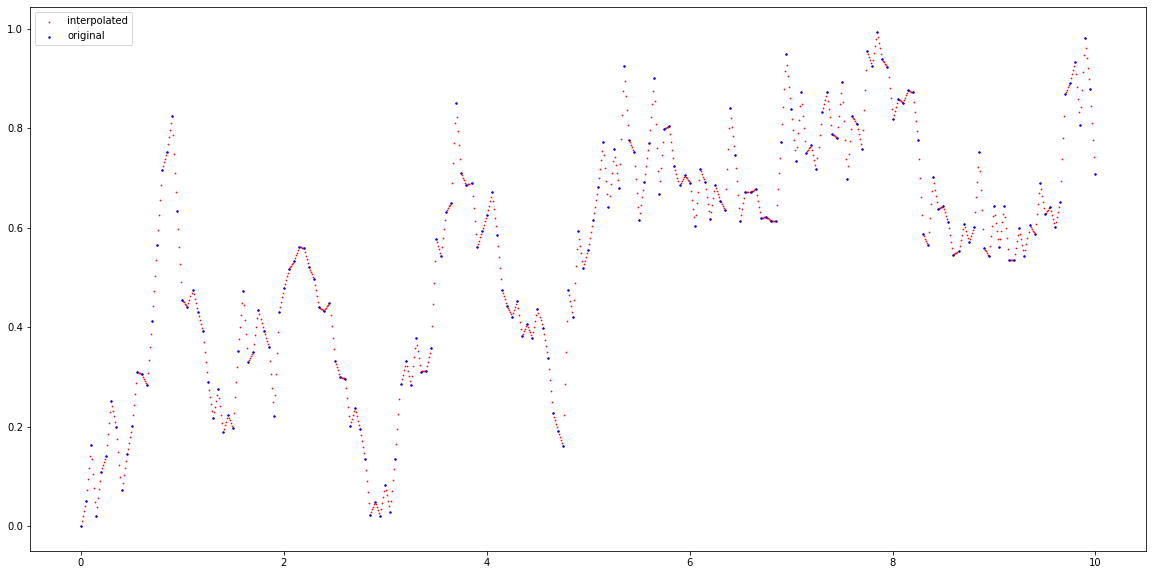

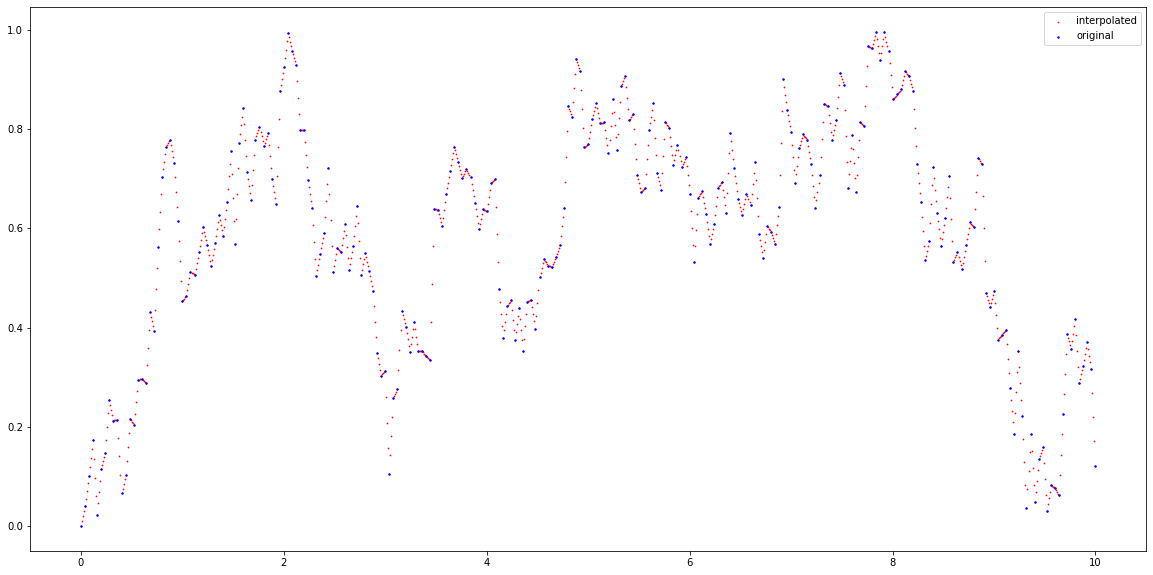

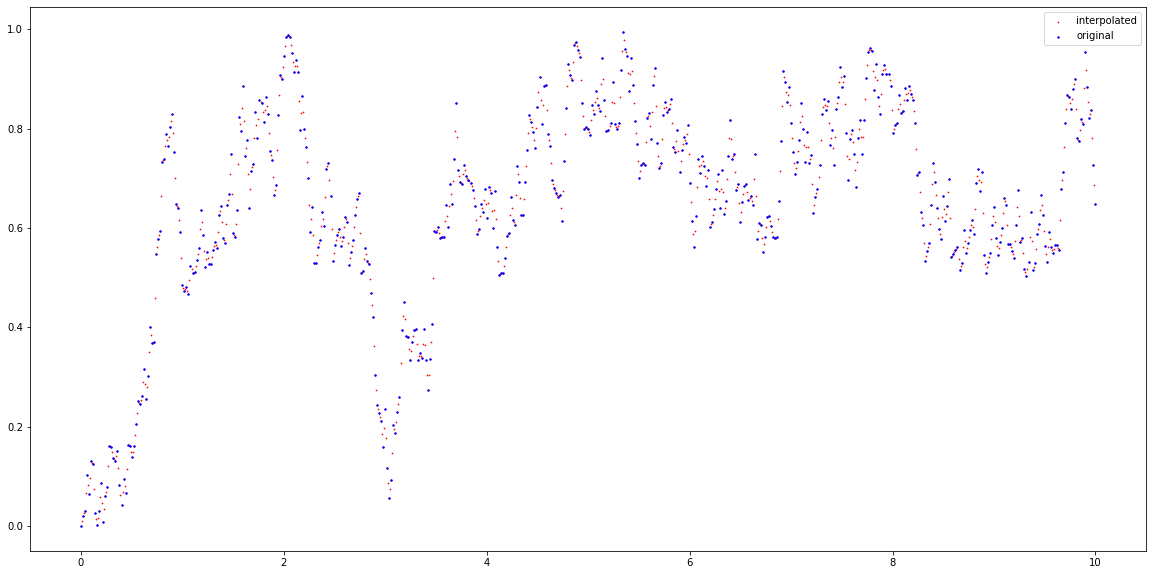

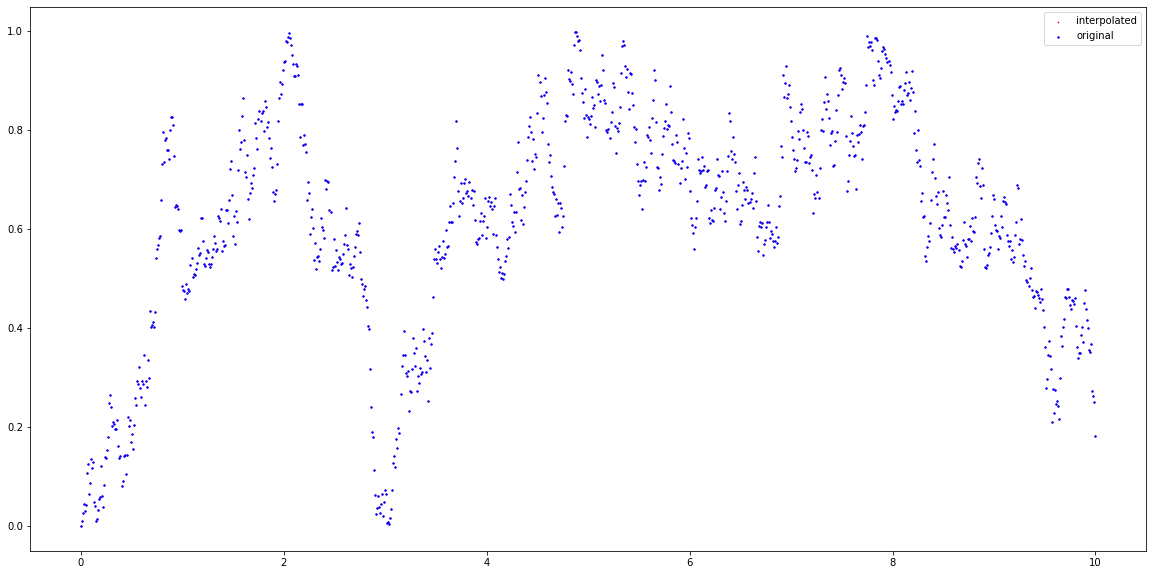

In [4]:
iterlist = np.arange(1,10)
iterlist = iterlist[::-1] #reverse iterlist to plot highest resolution to lowest resolution
maxnth = iterlist[0]

particles = []
baseSteps = 1000
for i in tqdm(iterlist):
    if baseSteps%i == 0:
        ts, ws, dws, dt = getWeinerSubset(i,baseSteps,10,0)
        particle = Particle(0)
        zs = particle.simulate(ts, dws, dt)
        particles.append(particle)

        plt.plot(ts,zs, label = dt, color = (1-(maxnth-i)/maxnth, 0, 1-i/maxnth))

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

zeroParticle = particles[-1]  #Highest resolution track
zeroZs = np.array(zeroParticle.zs)
zeroTs = np.array(zeroParticle.ts)
for particle in tqdm(particles):
    zs = np.array(particle.zs)
    ts = np.array(particle.ts)
    zs_interpolated = np.interp(zeroTs, ts, zs)
    plt.figure(figsize=(20,10))
    plt.scatter(zeroTs, zs_interpolated, s= 0.5, color = "red", label = "interpolated")
    plt.scatter(ts, zs, s= 2,color = "blue", label = "original")
    plt.legend()
    print(particle.dt)

Simulate particle with same noise at different dt

  0%|          | 0/999 [00:00<?, ?it/s]

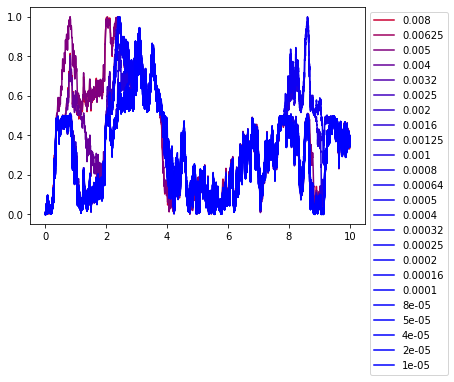

In [14]:
iterlist = np.arange(1,1000)
iterlist = iterlist[::-1] #reverse iterlist to plot highest resolution to lowest resolution
maxnth = iterlist[0]

particles = []
resolutions = []
baseSteps = 1000000
for i in tqdm(iterlist):
    if baseSteps%i == 0:
        ts, ws, dws, dt = getWeinerSubset(i,baseSteps,10,0)
        particle = Particle(0)
        zs = particle.simulate(ts, dws, dt)
        particles.append(particle)

        plt.plot(ts,zs, label = dt, color = (1-(maxnth-i)/maxnth, 0, 1-i/maxnth))
        resolutions.append(dt)

plt.legend(bbox_to_anchor=(1, 1))
plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

<ipython-input-15-93b6825f5ceb>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))


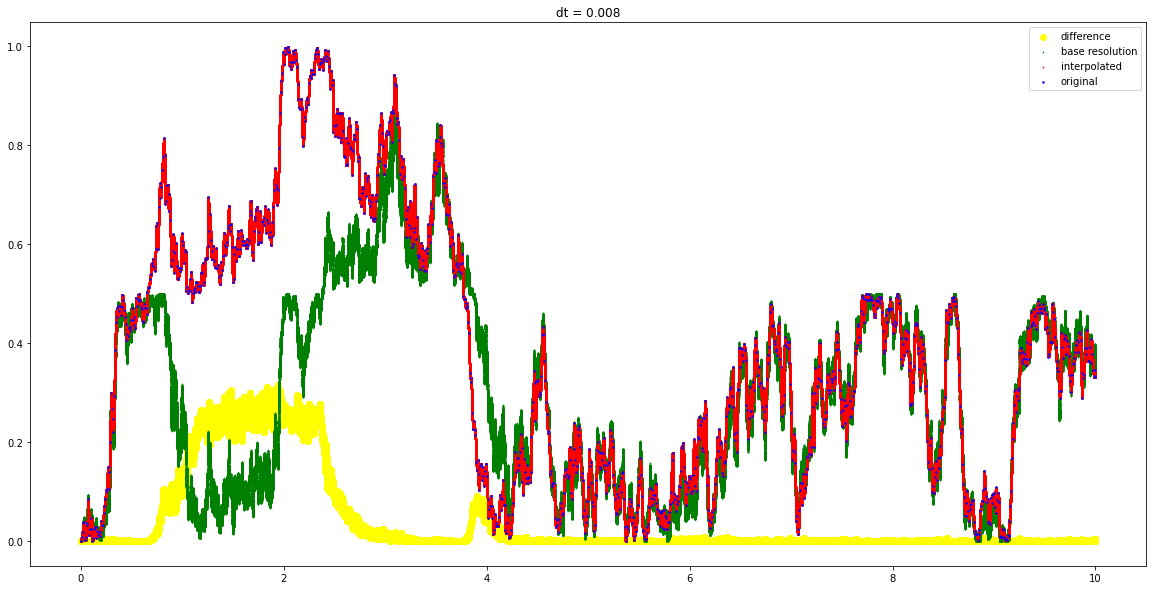

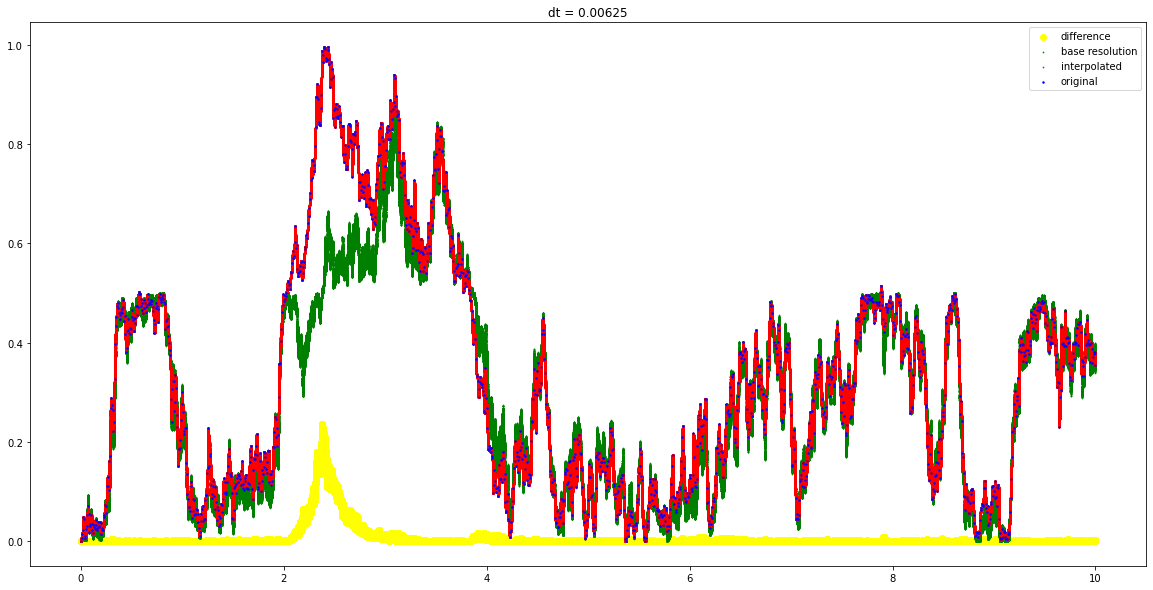

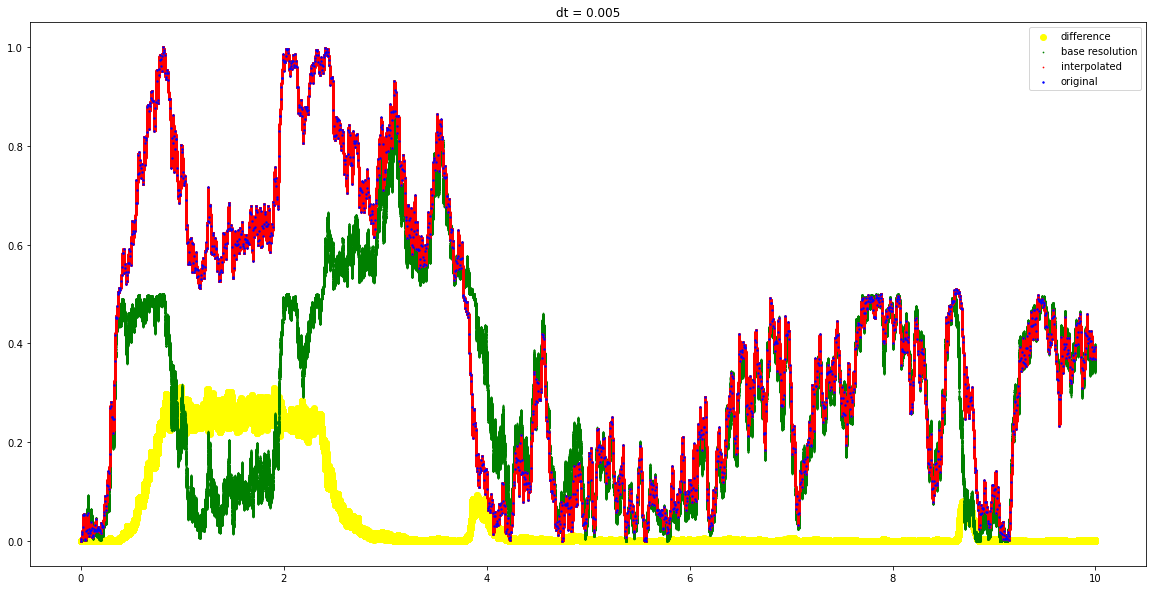

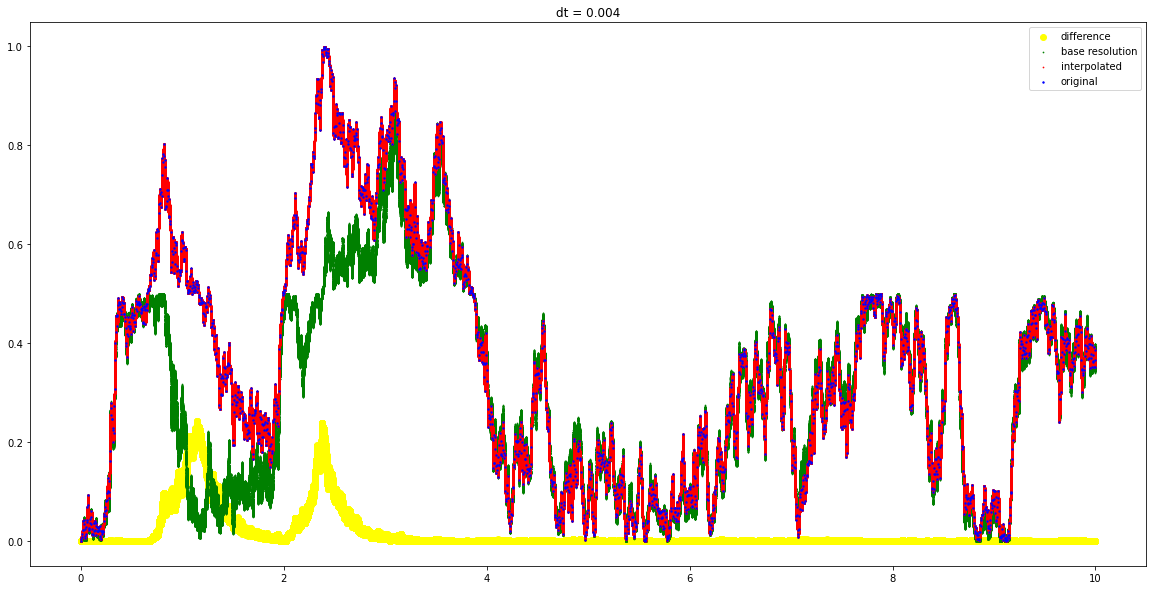

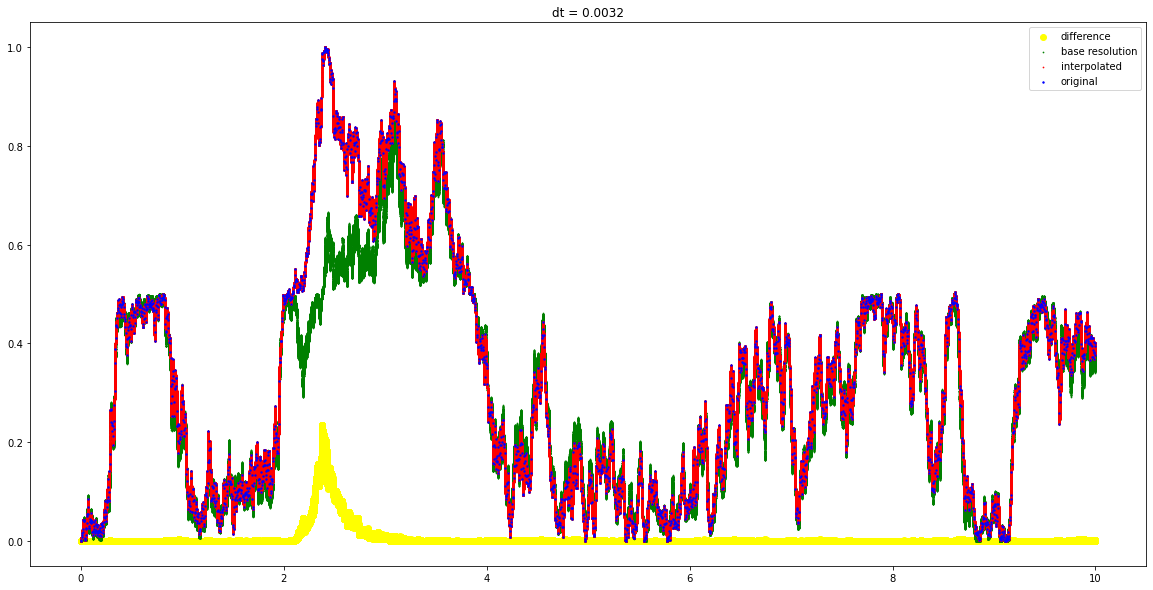

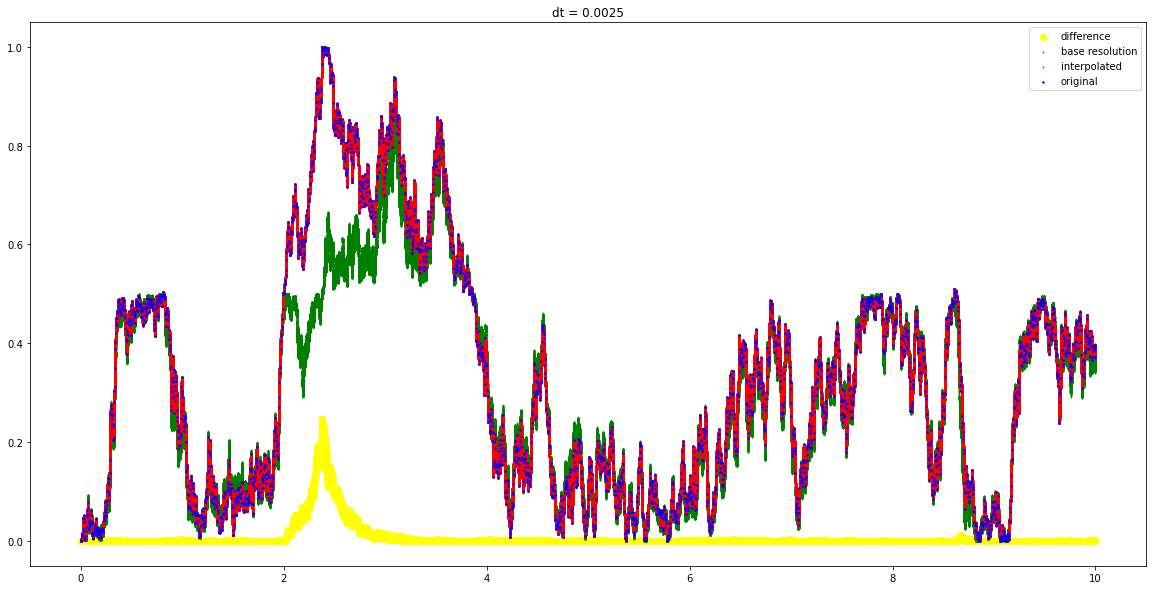

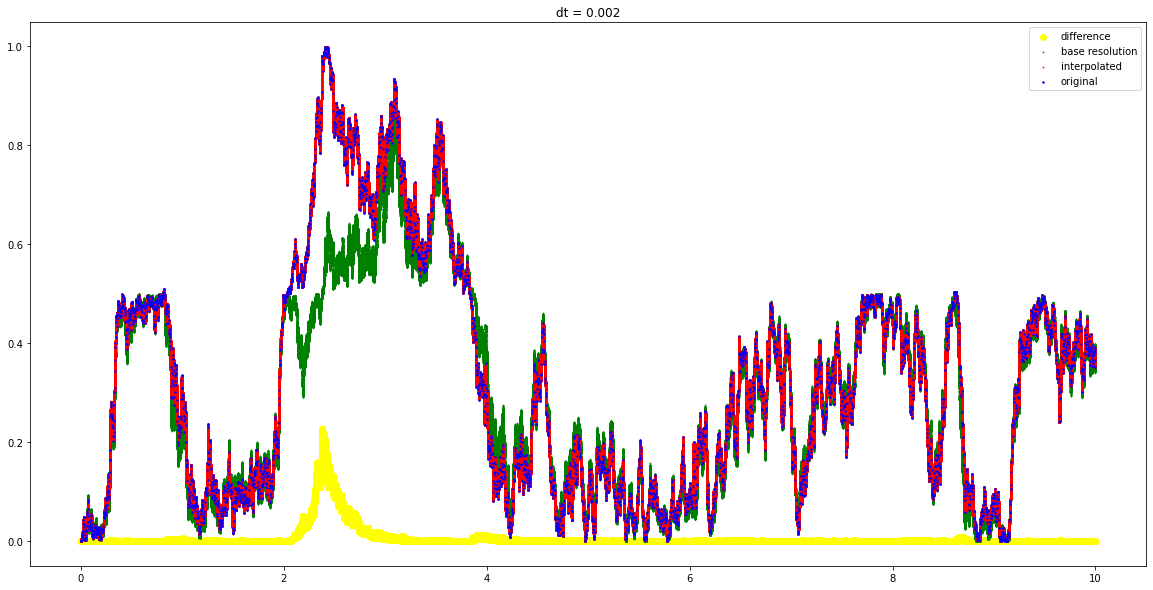

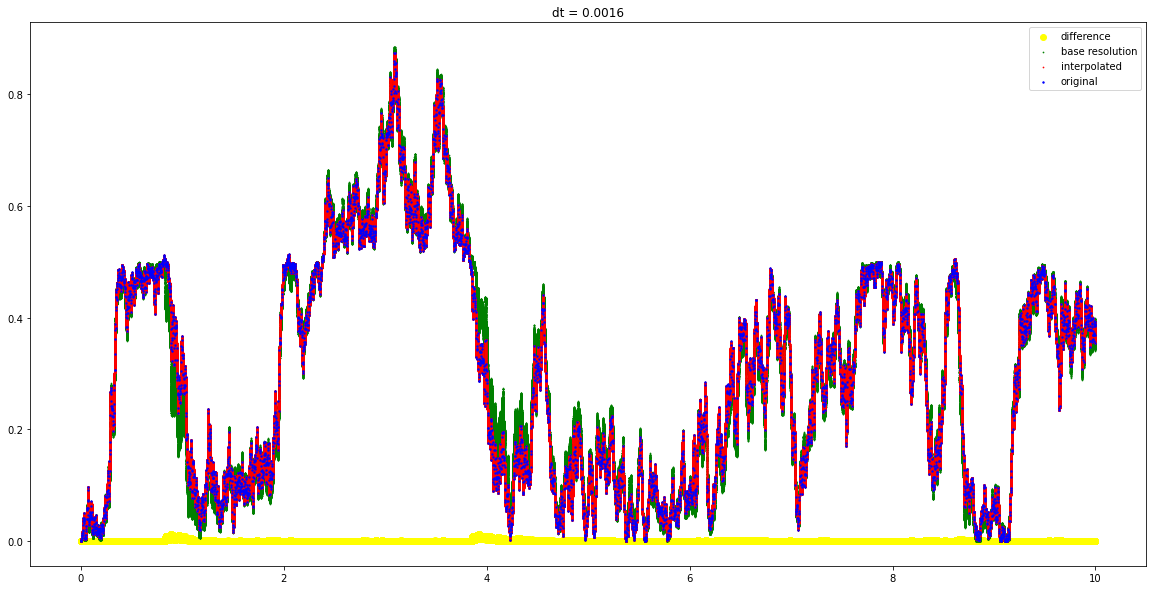

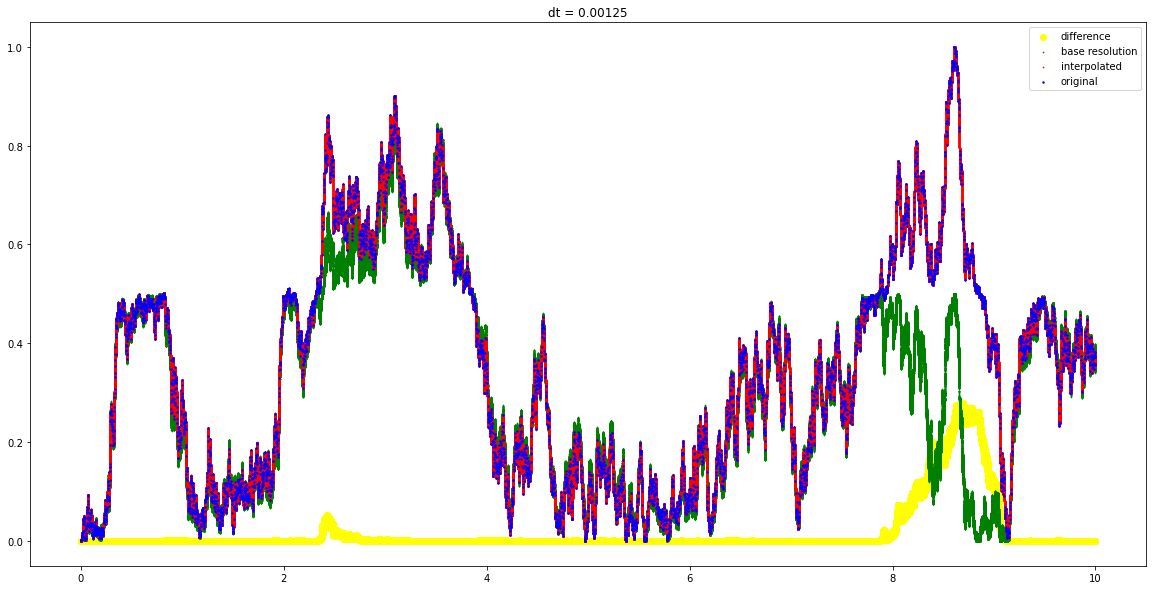

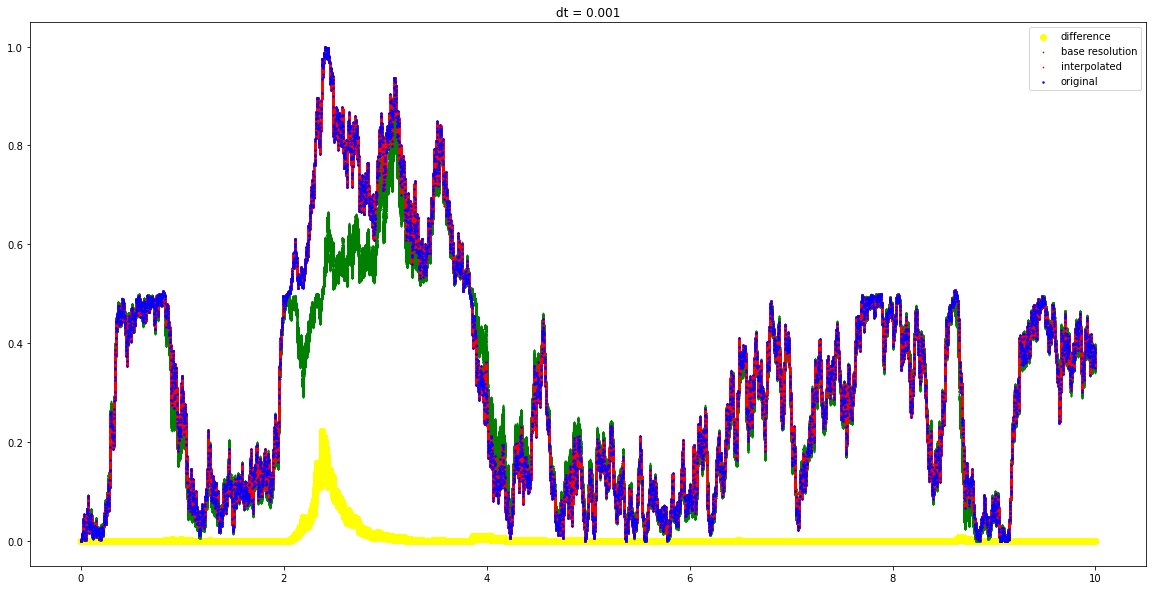

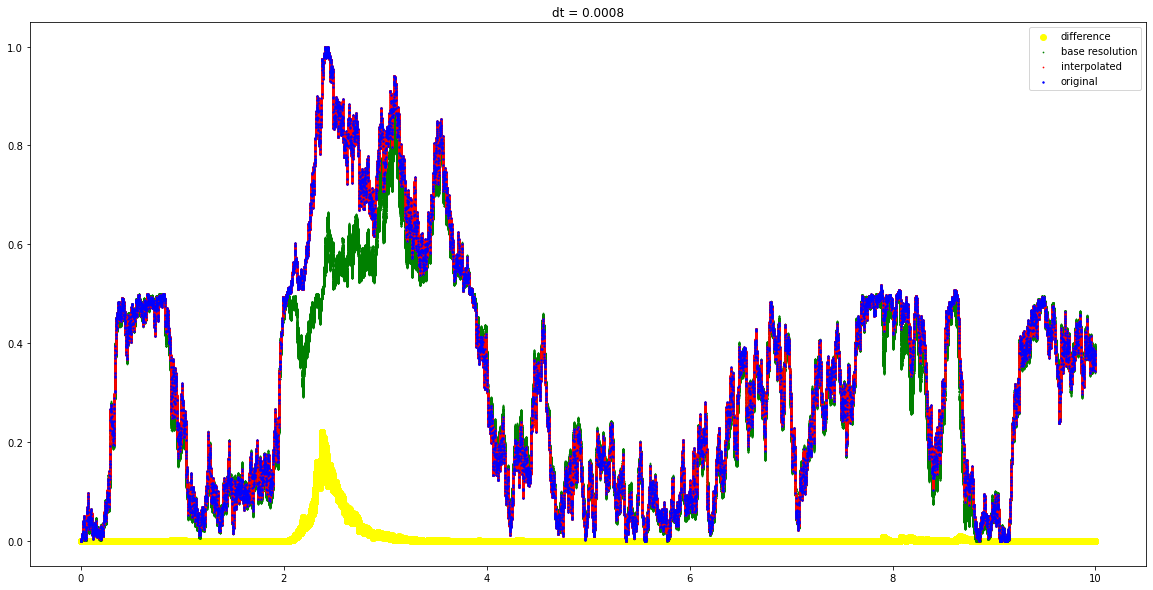

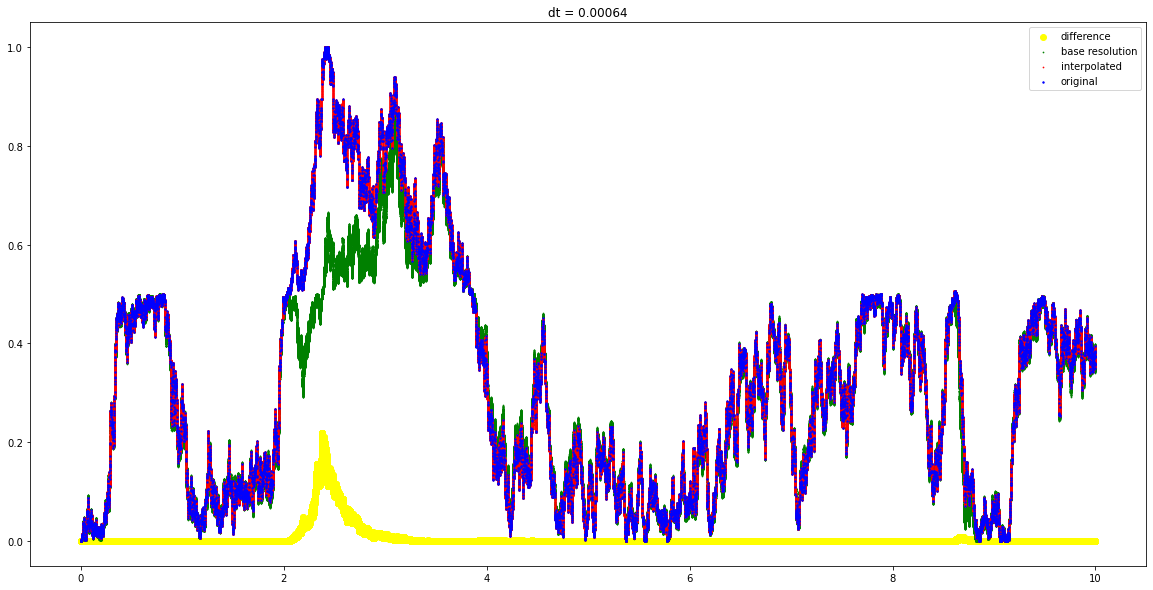

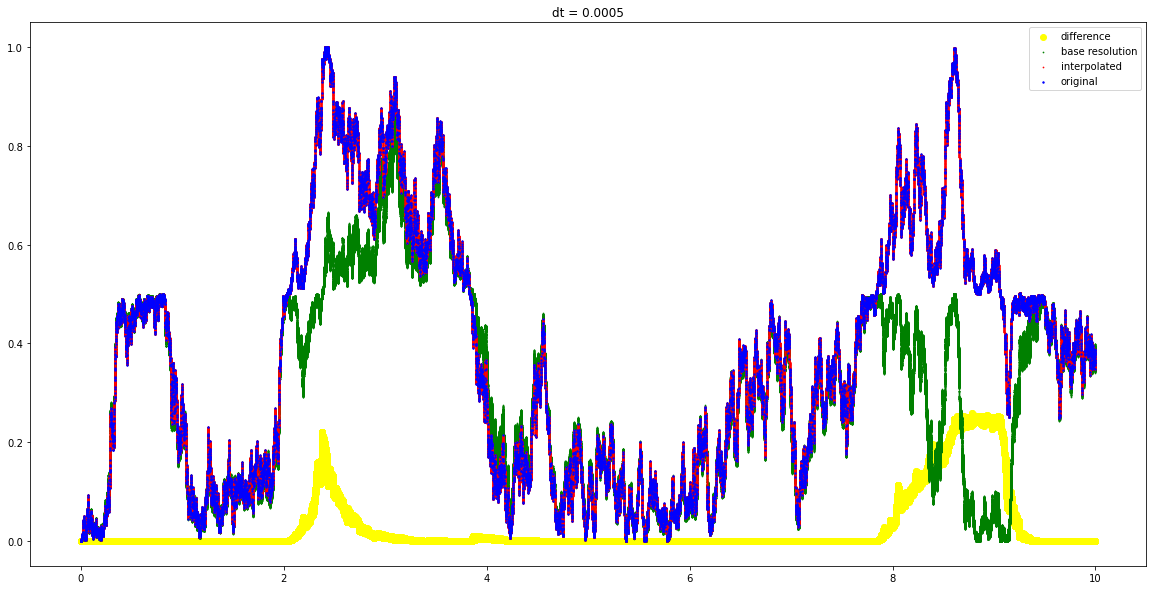

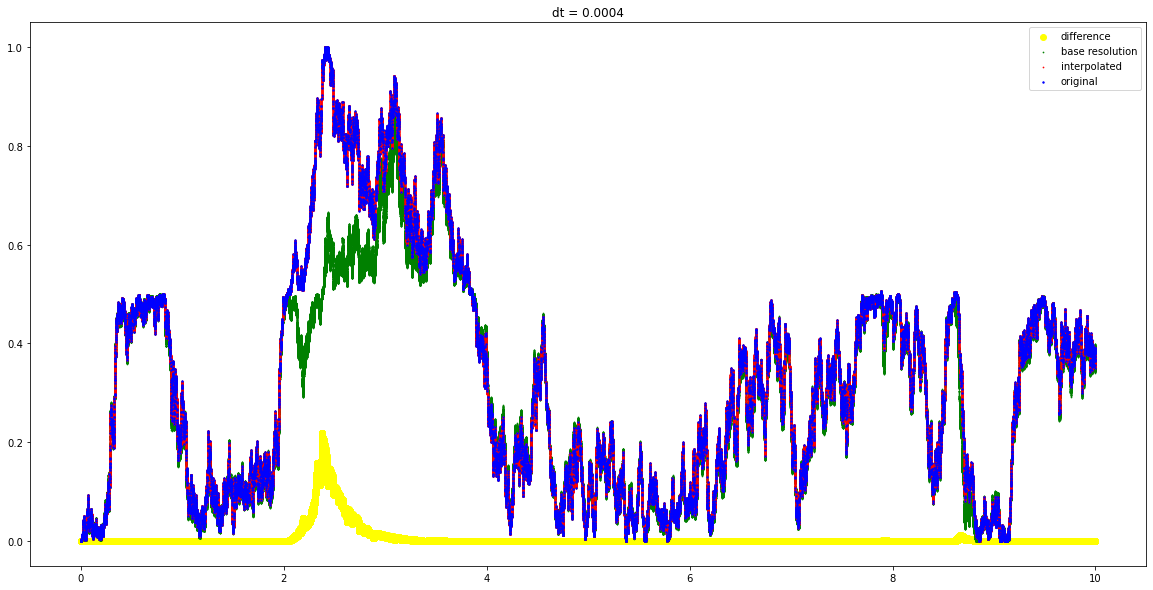

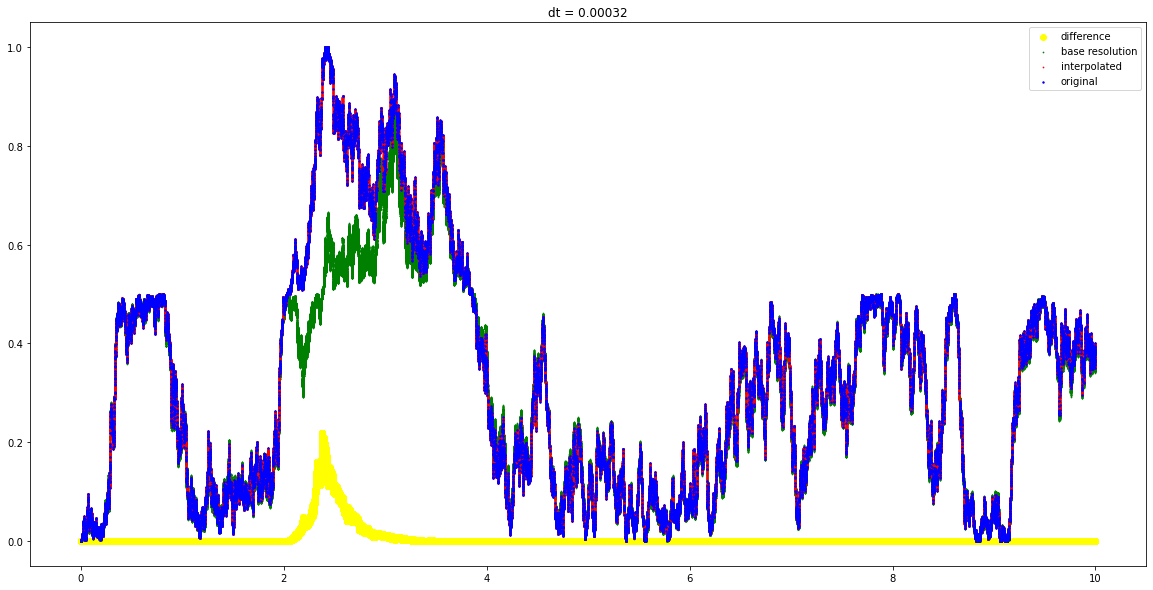

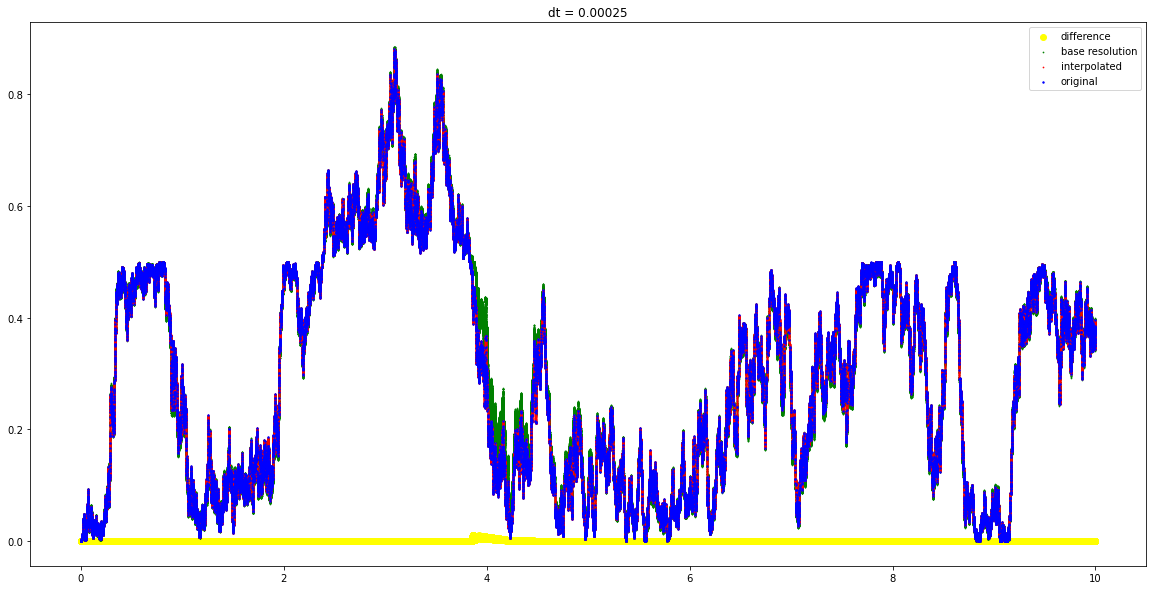

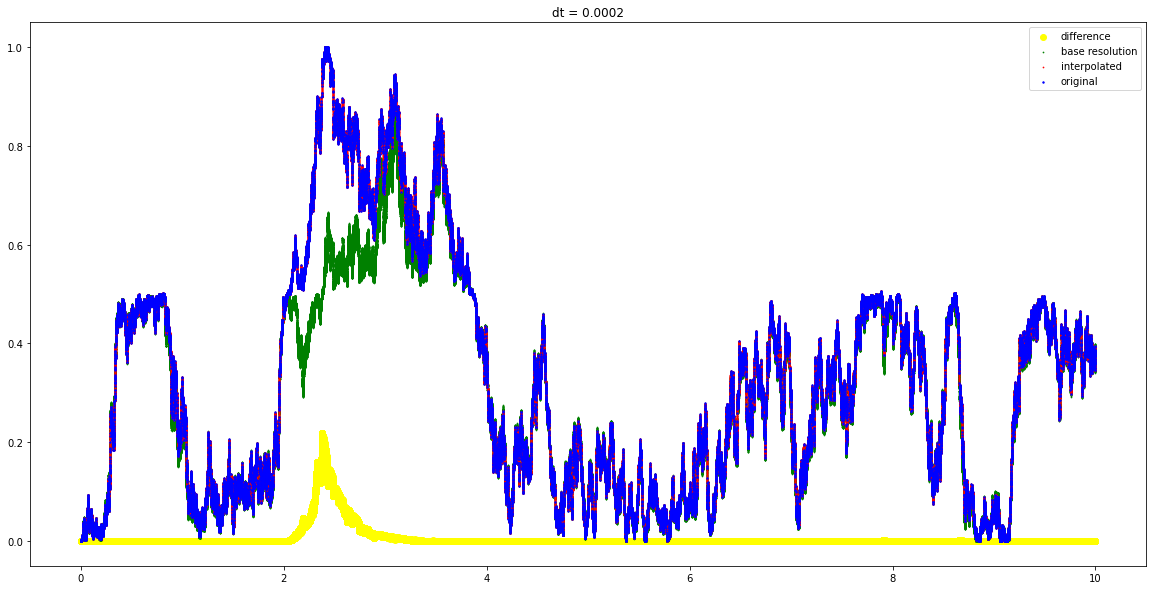

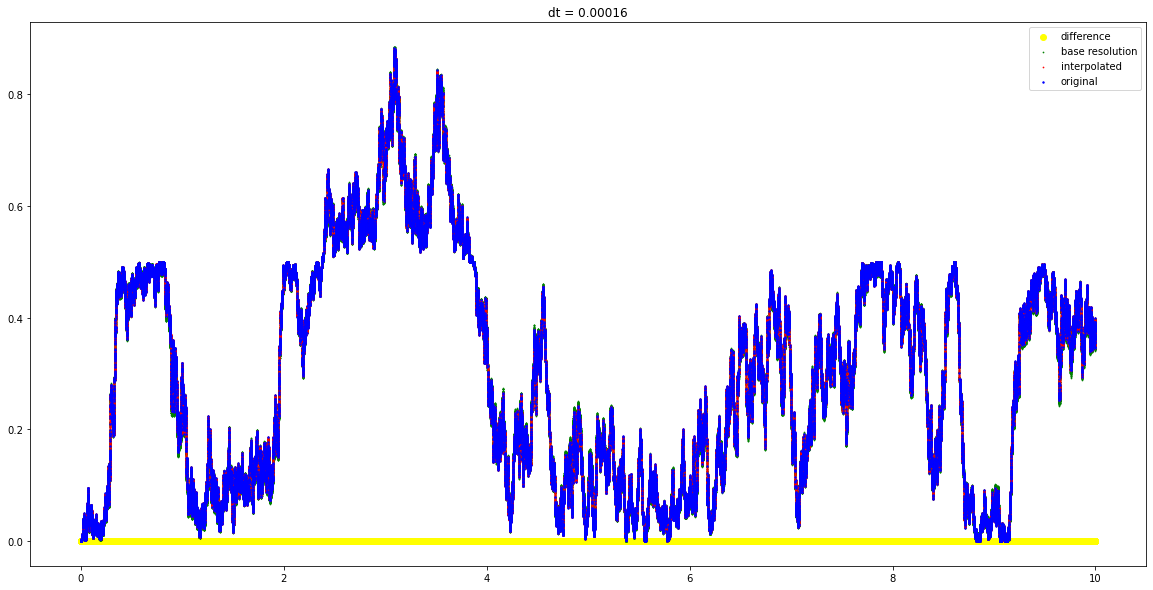

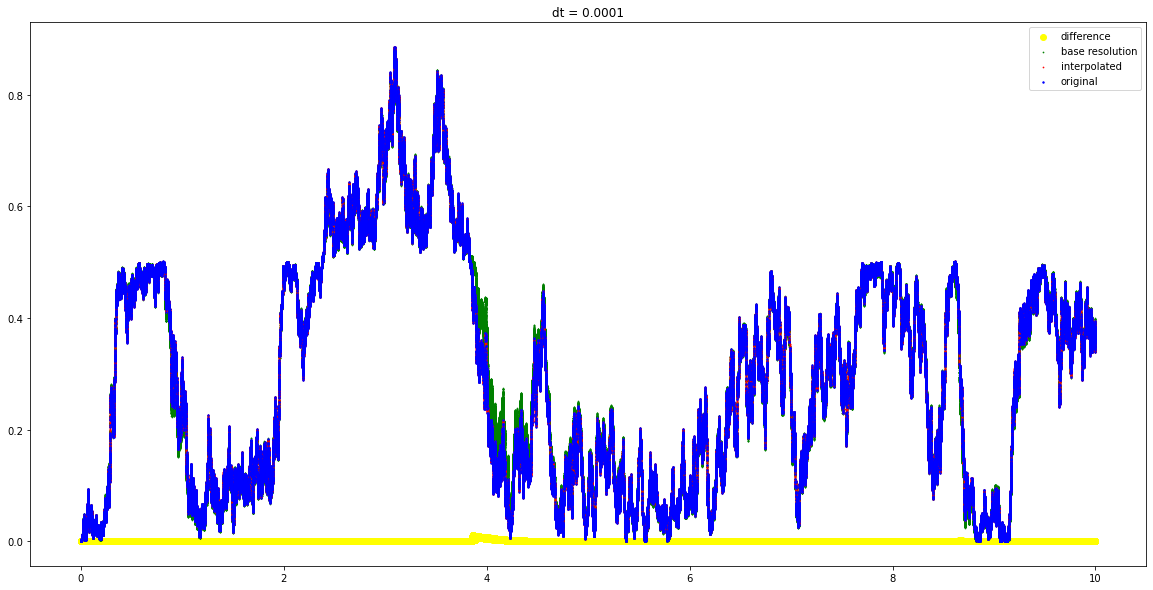

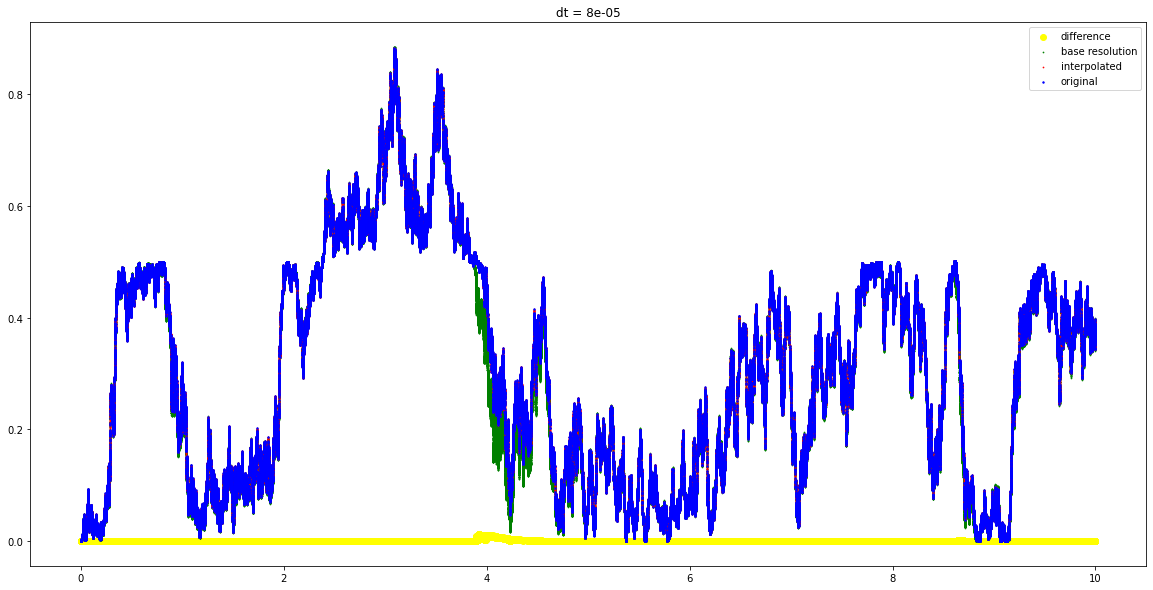

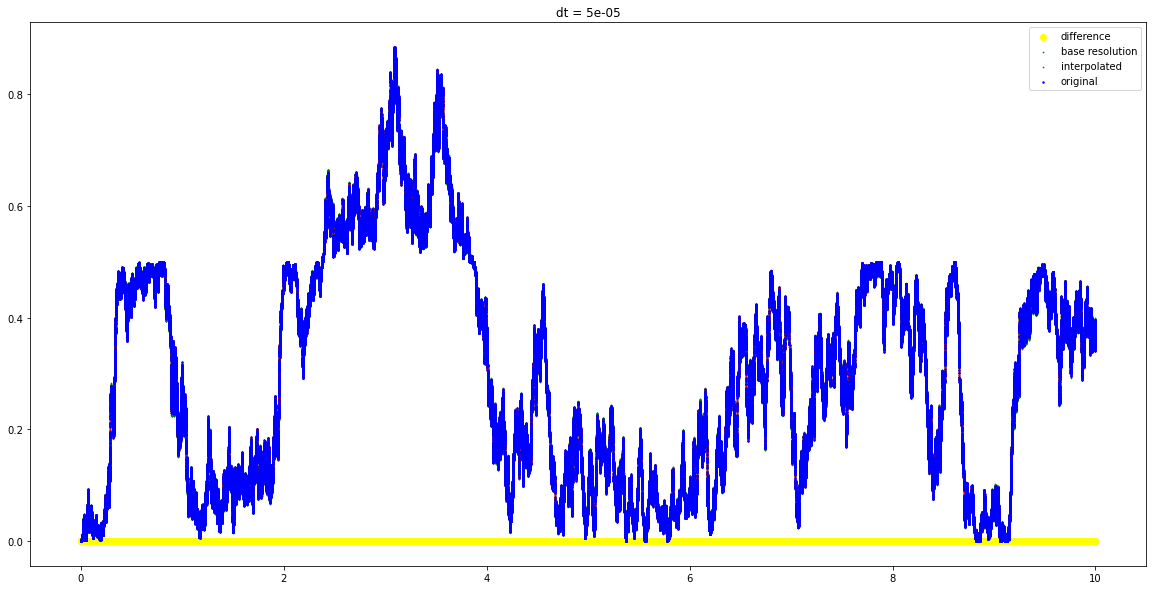

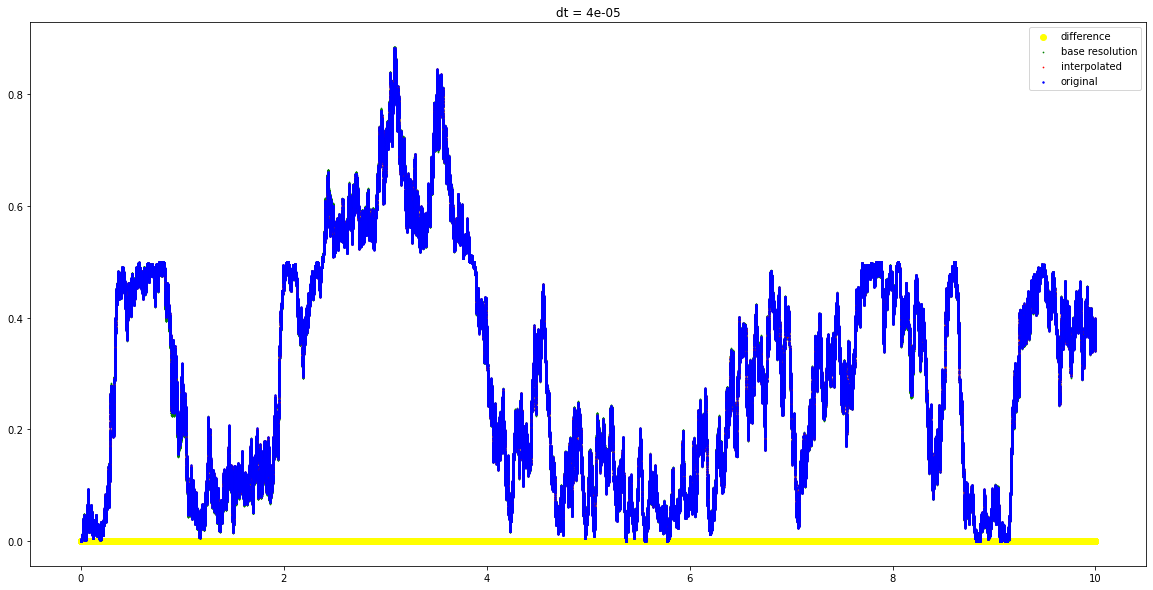

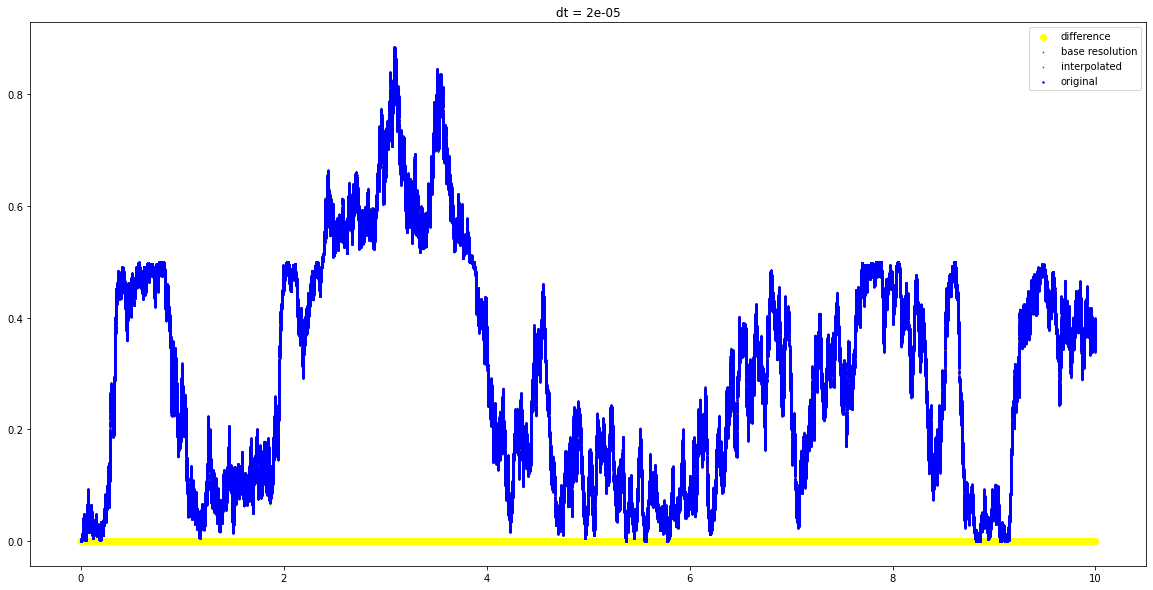

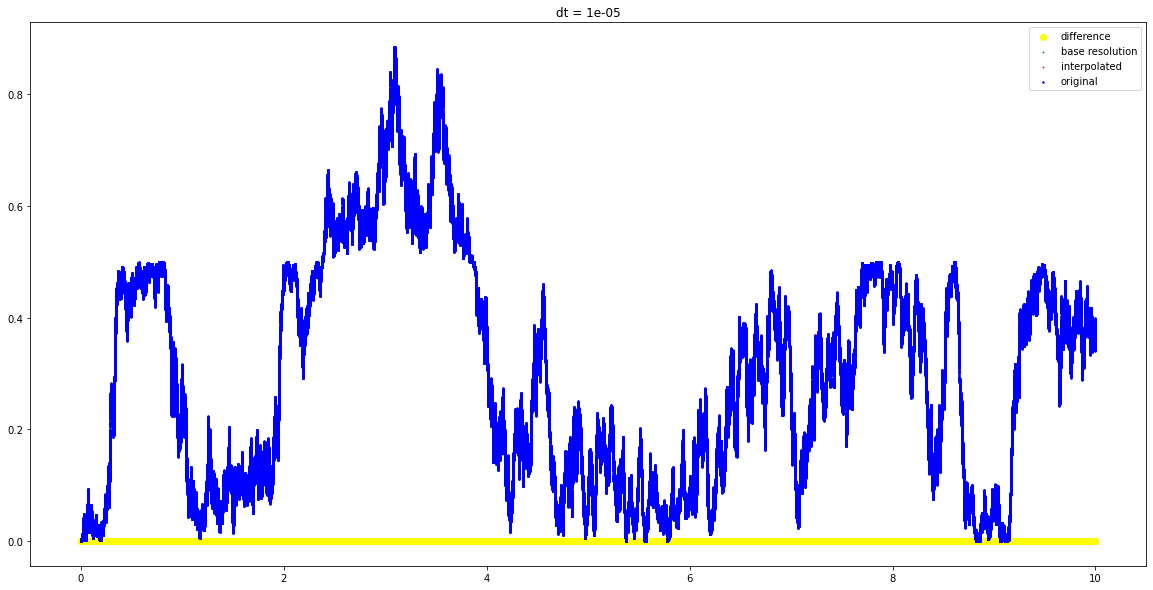

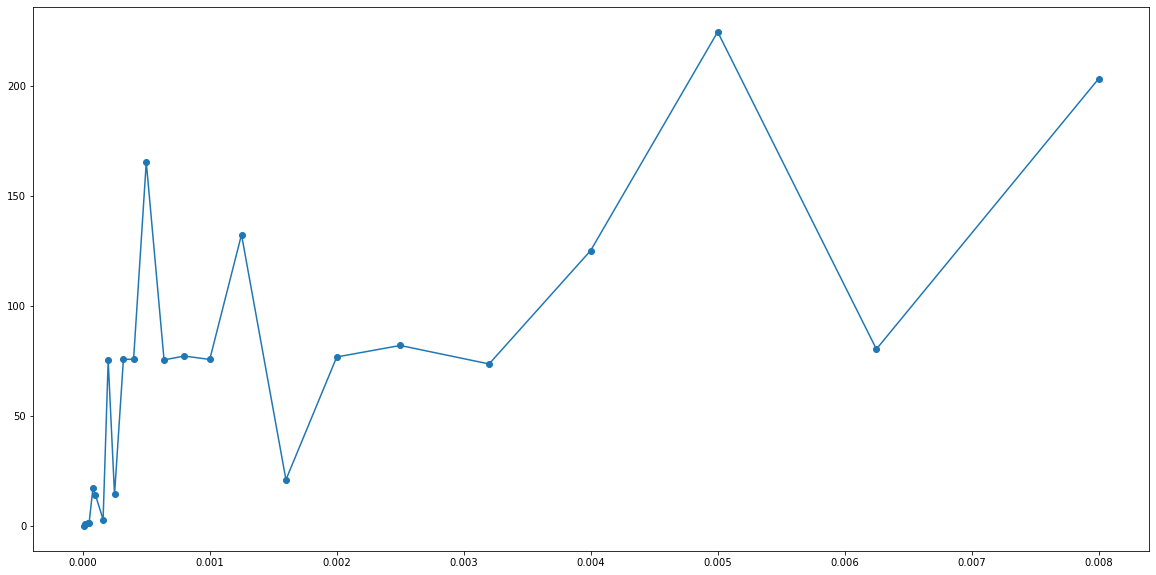

In [15]:
zeroParticle = particles[-1]  #Highest resolution track
zeroZs = np.array(zeroParticle.zs)
zeroTs = np.array(zeroParticle.ts)
deltas = []
for particle in tqdm(particles):
    zs = np.array(particle.zs)
    ts = np.array(particle.ts)
    zs_interpolated = np.interp(zeroTs, ts, zs)
    delta = np.linalg.norm(zeroZs - zs_interpolated, ord = 2)
    deltas.append(delta)
    plt.figure(figsize=(20,10))
    plt.scatter(zeroTs, (zeroZs - zs_interpolated)**2, color = "yellow", label ="difference")
    plt.scatter(zeroTs, zeroZs, s= 0.5, color = "green", label = "base resolution")
    plt.scatter(zeroTs, zs_interpolated, s= 0.5, color = "red", label = "interpolated")
    plt.scatter(ts, zs, s= 2,color = "blue", label = "original")
    plt.legend()
    plt.title(f"dt = {particle.dt}")

plt.figure(figsize=(20,10))
plt.plot(resolutions, deltas, marker = "o")